    - Questions:
        - is the COP of a cascade-HP always higher than a single-stage?
        - in the cascade, we break down the compressor pressure ratio (PR) into multiple smaler PR's.
            - if the compressor work is a power-function of the PR (with a exponent > 1), breaking it down should give us a smaller work consumption
            - example for quadratic function: 
                - W_single_stage = (12 bar)**2 = 144
                - W_cascade_three_stages = 3*(4 bar)**2 = 48
        - one issue is that we lose compressor power to overcome the heat-exchangers' approach temepratures
            - ex: bottom-stage fluid at evaporator must be 5 C hotter than the upper-stage condenser
            - if we stack up these deltaT's, we would end up with a higher deltaT to overcome than the single-stage cycle 
        - This paper shows that the cascade has a lower COP than single-stage:
            - https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.834.3694&rep=rep1&type=pdf

    - Work seems to be a concave function, like a logarithmic function
        - it would make sense to operate at higher PR then... Why don't we do that?
            - outlet temperature gets too high?

    - From this link:
        - maximum compression ratio that a reciprocating can handle in one stage is limited mostly by compressed gas discharge temperature. The piston rod load generated by the compression ratio may also be a limit. Typical compression ratios are 1.2 to 4.0.
        - https://www.turbomachinerymag.com/view/centrifugal-vs-reciprocating-compressor
        
        - There is no real "mechanical" limitation on the compression ratio achievable by compressors, except for the relationship effects with temperature (strength reduction, oxidation, friction ...). Compressors are more limited by efficiencies, where an isothermal compression process is ideal, but a perfect isothermal process is impossible to achieve, because gases heat up when you compress them and you would need perfect heat transer - so, for a compromise, multiple stages are often used with intercoolers, and because of this phenomena, compression ratios are kept low. 1:4 normally, sometimes as high as 1:7 for some positive displacements (reciprocating, scroll, screw, ...) Note that the compression stages in newer higher performance turbines are running upwards of 1:25.
        - Reference: https://www.physicsforums.com/threads/what-is-the-maximum-compression-ratio.382311/
        
        - Compression ratios usually vary between 1.05–7 per stage; however, a ratio of 3.5–4.0 per stage is considered maximum for most process operations. Quite often, the temperature rise of the gas during the compression dictates a limit for the safe or reasonable pressure rise. The maximum temperature rise is governed either by the maximum operating temperature of the compressor cylinder, or by the maximum temperature that the gas can withstand before decomposition, polymerization or even auto-ignition as for chlorine, acetylene, etc. Because the volumetric efficiency decreases with an increase in compression ratio, this also adds to the selection of a reasonable limiting discharge pressure. With a known maximum temperature, the maximum ratio of compression can be calculated from the adiabatic temperature rise relation.
        - https://www.sciencedirect.com/topics/engineering/compression-ratio#:~:text=Compression%20ratios%20usually%20vary%20between,maximum%20for%20most%20process%20operations.
        - A. Kayode Coker, in Ludwig's Applied Process Design for Chemical and Petrochemical Plants (Fourth Edition), 2015



    - Volumetric Efficiency:
        - we need to represent a reduction in efficiency as the PR increases! which is not currently capctured by the constant isentropic efficiency model
            - instead of using volumetric efficiency, we could just simply derive a correlation of the isentropic efficiency w.r.t. the pressure ratio! Need to find sources for that
                - one source: https://journals.pan.pl/dlibra/publication/121248/edition/105639/content
                - we need to use the compressor curves!! isentropic eff is a function of the PR and 
        - Some references:
            - https://www.sciencedirect.com/topics/earth-and-planetary-sciences/volumetric-efficiency#:~:text=The%20volumetric%20efficiency%20represents%20the,to%20suction%20temperature%20and%20pressure.
            - Boyun Guo Ph.D., ... Ali Ghalambor Ph.D., in Petroleum Production Engineering, 2007
            - 

    - guidelines for choosing cascade systems:
        - when deltaT/deltaP is too high for a single stage:
            - final T or P (condenser saturation T, not compressor outlet),  above supercritical point
            - outlet T above 400 F: 
                - equipment degradation: strength reduction, oxidation, friction
                - fluid decomposition, polymerization or even auto-ignition 
            - other physical problems with high pressure ratio: 
                - 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


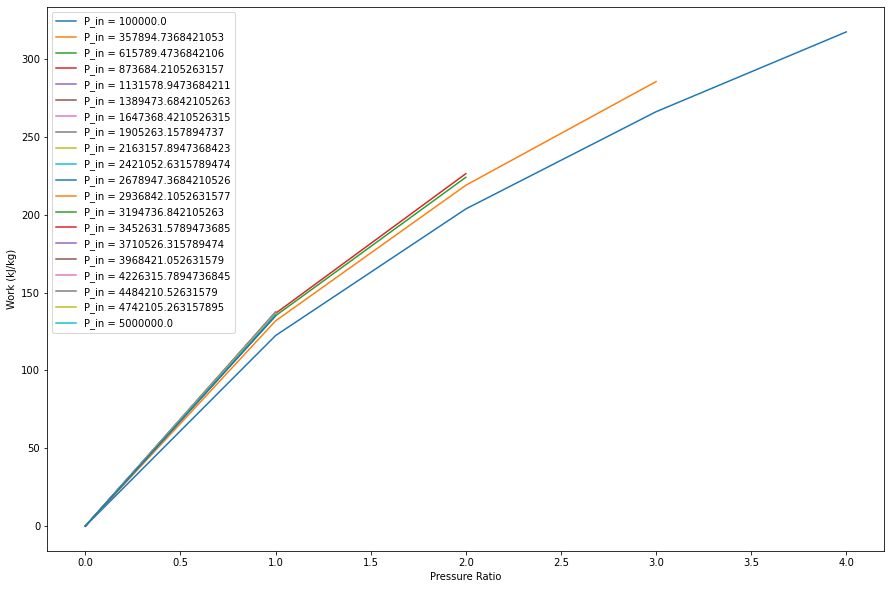

In [34]:
# checking compression work as a function of the delta P

n = 20
Pin_range = np.linspace(1, 50, n)
# Pin_range = [10]
PR_range = np.linspace(1, 20, n) 

n = len(PR_range)
m = len(Pin_range)

work_matrix = np.zeros( (n, m) )
Qh_matrix = np.zeros( (n, m) )
COP_matrix = np.zeros( (n, m) )
Tout_matrix = np.zeros( (n, m) )
Tin_matrix = np.zeros( (n, m) )

plt.figure(figsize=(15,10))

for (j, Pin) in enumerate(Pin_range):
    
    print(j)
    
    Pin = Pin*1e5  # bar to Pa
    
    for (i, PR) in enumerate(PR_range):
        
        try:
        
            # compressor inlet
            Hin = PropsSI('H', 'P', Pin, 'Q', 1, 'ammonia')
            Sin = PropsSI('S', 'P', Pin, 'Q', 1, 'ammonia')
            Tin_matrix[i, j] = PropsSI('T', 'H', Hin, 'P', Pin, 'ammonia')

            # compressor outlet, condenser inlet
            Pout = Pin*PR
            Hout_isentropic = PropsSI('H', 'S', Sin, 'P', Pout, 'ammonia')
            Hout = Hin + (Hout_isentropic - Hin)/0.7
            work_matrix[i, j] = (Hout-Hin)/1e3

            # condenser outlet
            Tcond = PropsSI('T', 'P', Pout, 'H', Hout, 'ammonia')
            Hcond_out = PropsSI('H', 'T', Tcond, 'Q', 0, 'ammonia')
            Qh_matrix[i, j] = (Hout-Hcond_out)/1e3

            if work_matrix[i, j] > 0:
                COP_matrix[i, j] = Qh_matrix[i, j]/work_matrix[i, j]
            else:
                COP_matrix[i, j] = np.nan

            Tout_matrix[i, j] = PropsSI('T', 'H', Hout, 'P', Pout, 'ammonia')
    
        except:
            
            work_matrix[i, j] = np.nan
            Tout_matrix[i, j] = np.nan
            Tin_matrix[i, j] = np.nan
            Qh_matrix[i, j] = np.nan
            COP_matrix[i, j] = np.nan
    
    plt.plot(work_matrix[:, j], label=f'P_in = {Pin}')
    plt.ylabel('Work (kJ/kg)')
    
#     plt.plot(Tout_matrix[:, j], label=f'P_in = {Pin}')
#     plt.ylabel('Tout (K)')
    
#     plt.plot(Tout_matrix[:, j]-Tin_matrix[:, j], label=f'P_in = {Pin/1e5:.2f} bar')
#     plt.ylabel('Compression Temperature Increase (C)')
    
    plt.xlabel('Pressure Ratio')
    
plt.legend()
    

Text(0.5, 0, 'Pressure Ratio')

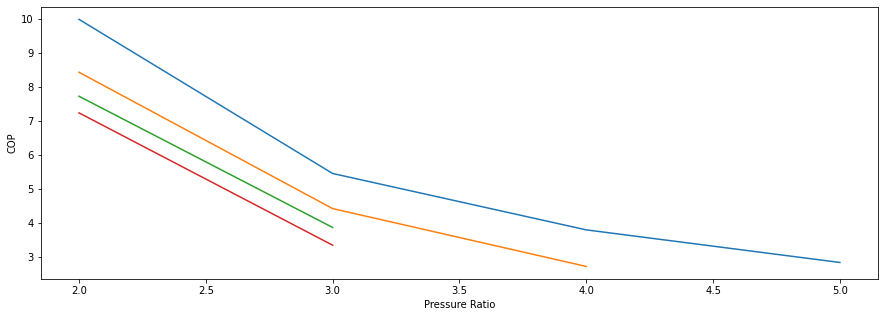

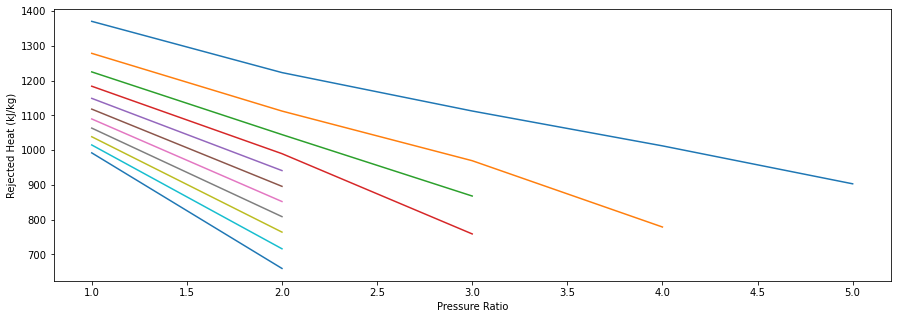

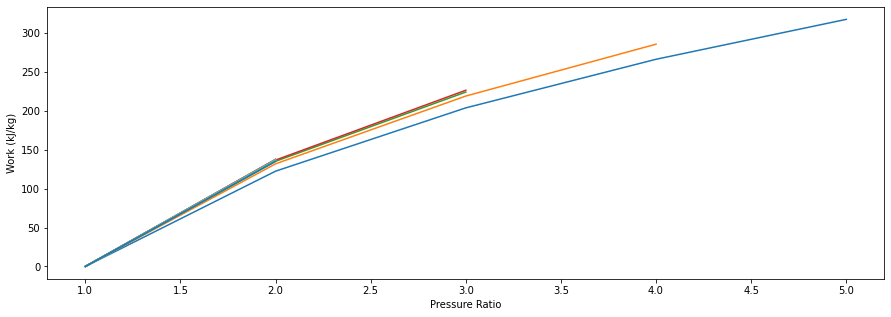

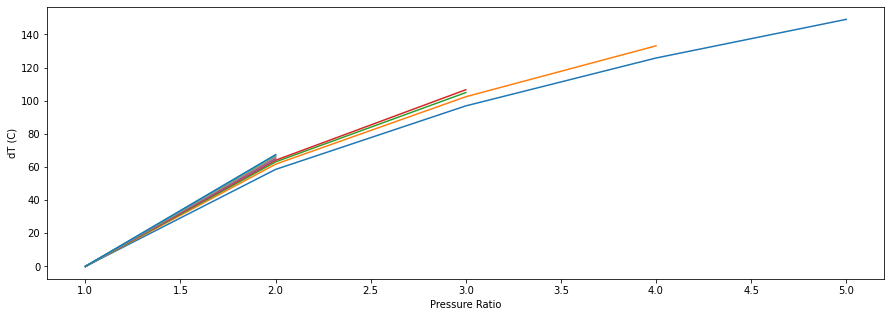

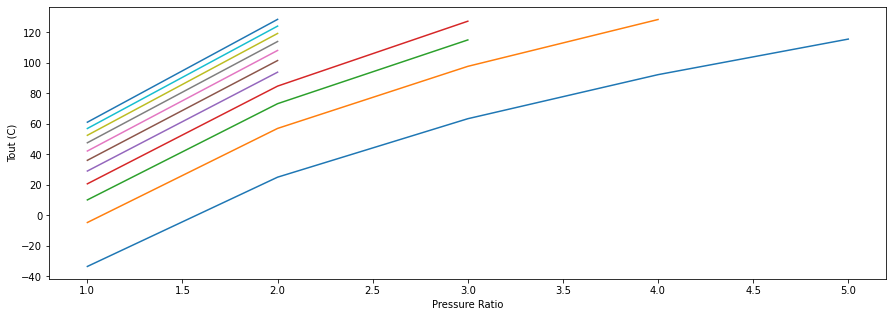

In [35]:
plt.figure(figsize=(15,5))
plt.plot(PR_range, COP_matrix);
plt.ylabel('COP')
plt.xlabel('Pressure Ratio')

plt.figure(figsize=(15,5))
plt.plot(PR_range, Qh_matrix);
plt.ylabel('Rejected Heat (kJ/kg)')
plt.xlabel('Pressure Ratio')

plt.figure(figsize=(15,5))
plt.plot(PR_range, work_matrix);
plt.ylabel('Work (kJ/kg)')
plt.xlabel('Pressure Ratio')

plt.figure(figsize=(15,5))
plt.plot(PR_range, Tout_matrix-Tin_matrix);
plt.ylabel('dT (C)')
plt.xlabel('Pressure Ratio')

plt.figure(figsize=(15,5))
plt.plot(PR_range, Tout_matrix-273);
plt.ylabel('Tout (C)')
plt.xlabel('Pressure Ratio')


# Imports

In [1]:
# from heat_pump_model import heat_pump
from libraries import * 
from refrigerant_properties import *
import numpy as np
from utilities.unit_defs import Q_
import matplotlib.pyplot as plt

# HP Model (easier to change it this way)

In [2]:
##### Importing Libraries #####
# Libraries below are used to pull from for the Heat Pump model
from array import array
import math
import numpy as np
import numpy_financial as npf
import pandas as pd
import requests
import csv
import CoolProp
import yaml
import sys

from CoolProp.CoolProp import PropsSI 
from CoolProp.Plots import PropertyPlot
from CoolProp.Plots import SimpleCompressionCycle

from libraries import *
from refrigerant_properties import*
from utilities.unit_defs import ureg, Q_
# from uncertainties import ufloat as uf
# from uncertainties import unumpy as unp

## Note: Default values set to -1.0 need to be calculated and are initialized, but will 
## return an error if not calculated first.

##### Initialization #####
## This class calls the heat pump model and initializes it to dummy values.
class heat_pump:
    ##### Model Variables #####
    def __init__(self):

        ##### 1.COP #####
        ## Outputs
        self.ideal_COP = np.array([-1.0]*2)*ureg.dimensionless
        self.actual_COP = np.array([-1.0]*2)*ureg.dimensionless
        self.refrigerant = []

        ##### 2.Energy and Mass Flow #####
        ## Outputs
        self.cold_final_temperature = Q_(np.array([-1.0]*2), 'degC')
        self.power_in = Q_(np.array([-1.0]*2), 'kW') # Gives the Energy into the heat pump in power
        self.average_power_in = Q_('-1.0 kW')
        self.annual_energy_in = Q_('-1.0 MW*hr')

        ##### 3.Heat Pump Costs #####
        ## Outputs
        self.capital_cost = Q_('-1.0 USD')
        self.year_one_energy_costs = Q_('-1.0 USD/yr')
        self.year_one_fixed_o_and_m = Q_('-1.0 USD/yr')
        self.year_one_variable_o_and_m = Q_('-1.0 USD/yr')
        self.year_one_operating_costs = Q_('-1.0 USD/yr')
        self.LCOH = Q_('-1.0 USD / MMMBtu')
        self.capacity_factor = Q_('-1.0')
        
        ##### 4. Natural Gas Costs #####
        ## Outputs
        self.gas_capital_cost = Q_('-1.0 USD')
        self.gas_year_one_energy_costs = Q_('-1.0 USD/yr')
        self.gas_year_one_fixed_o_and_m = Q_('-1.0 USD/yr')
        self.gas_year_one_variable_o_and_m = Q_('-1.0 USD/yr')
        self.gas_year_one_operating_costs = Q_('-1.0 USD/yr')
        self.gas_LCOH = Q_('-1.0 USD / (MW * hr)')

        ##### 5. Cash Flow Model #####
        self.net_present_value = Q_('0.0 USD')
        self.internal_rate_of_return = Q_('-1.0')
        self.payback_period = Q_('100.0 yr')

        self.n_hrs = 8760

        self.construct_yaml_input_quantities('model_inputs.yml')


    def construct_yaml_input_quantities(self, file_path):
        with open(file_path, "r") as file_desc:
            input_dict = yaml.safe_load(file_desc)

        for key in input_dict:
            var = input_dict[key]
            try:
                if not isinstance(var, dict):
                    continue
                else:
                    quant = Q_(var['val'], var['unit'])
                input_dict[key] = quant
            except KeyError:
                print('Something is wrong with input variable ' + key)
                quit()
        self.__dict__.update(input_dict)


    def make_input_quantity(self, input_yaml_str):
        input_dict = yaml.safe_load(input_yaml_str)
        for key in input_dict:
            var = input_dict[key]
            try:
                if not isinstance(var, dict):
                    continue
                else:
                    quant = Q_(var['val'], var['unit'])
                input_dict[key] = quant
            except KeyError:
                print('Something is wrong with input variable ' + key)
                quit()
        self.__dict__.update(input_dict)

    
    def mysum(self, array_or_float):
        try:
            if len(array_or_float.magnitude) > 1.0:
                return np.sum(array_or_float)
            else:
                return self.n_hrs*array_or_float
        except(TypeError):
            return self.n_hrs*array_or_float


    ## This subroutine within the heat pump class Initializes the heat pump to a process in the process library.
    ## This initialization is not essential as all values can be input individually, but this module is built to 
    ## simplify the building of the models.
    def initialize_heat_pump(self,sector,process_name):
        self.hot_temperature_desired = Q_(np.array([process[sector][process_name]['hot_temperature_desired']]*self.n_hrs), 'degC')
        self.hot_temperature_minimum = Q_(np.array([process[sector][process_name]['hot_temperature_minimum']]*self.n_hrs), 'degC')
        self.hot_specific_heat = Q_(working_fluid[process[sector][process_name]['hot_working_fluid']]['specific_heat'], 'kJ / kg / degK')
        self.cold_temperature_available = Q_(np.array([process[sector][process_name]['waste_temperature']]*self.n_hrs), 'degC')

    ##### Model Calculations #####
    ## Calculating the COP
    def calculate_COP(self):
        
        # Calculating the ideal COP to begin with, this will be independent of the future anlaysis.
        self.ideal_COP = ((self.hot_temperature_desired.to('degK') + self.hot_buffer.to('degK')) )/((self.hot_temperature_desired.to('degK') + self.hot_buffer.to('degK')) - (self.cold_temperature_available.to('degK') - self.cold_buffer.to('degK')))

        if self.second_law_efficiency_flag == True:
            # If the carnot efficiency factor is true calculation the actual COP
            self.actual_COP = self.ideal_COP * self.second_law_efficiency
        else:
            # If the carnot efficiency factor is false requires more work in several steps
            # 1. If no refrigerant is selected pick one
            # 2. Using selected refrigerant calculate compressor efficiency
            # 3. Calculate actual COP from compressor efficiency
            # 4. Throw an error if calculation could not be completed.

            # Below will attempt to choose a refrigerant and calculate a realistic compressor efficiency from it, if this fails, it will revert to the carnot efficiency factor methodology
            ## Estimating Refrigerant Performance
            if self.refrigerant_flag != True:
                self.refrigerant = []
                for test_refrigerant in refrigerants:
                    t_crit = Q_(PropsSI(test_refrigerant, 'Tcrit'), 'kelvin').to('degC')
                    ## Checking if the refrigerant's critical temperature is at least 30°C > than the process temp.
                    if t_crit > (np.amax(self.hot_temperature_desired) + self.t_crit_delta):
                        self.refrigerant.append(test_refrigerant)
                
                print('Potential refrigerants include: ', self.refrigerant)
                ## Here the refrigerant with the lowest critical pressure, and therefore hopefully the lowest compression ratio
                ## is found and that will be recommended
                ## Need to update to reflect the fact that best refrigerant might not be the one with the lowest critical pressure
                min_p_crit = Q_('1e9 Pa')
                for test_refrigerant in self.refrigerant:
                    p_crit = Q_(PropsSI(test_refrigerant, 'Pcrit'), 'Pa')
                    if p_crit < min_p_crit:
                        min_p_crit = p_crit
                        self.refrigerant = test_refrigerant

            print('Selected refrigerant (based on user selection or minimual p_crit) is: ', self.refrigerant)

            ## Adjust such that this is below the Carnot Efficiency Factor 
            # Cycle calculation
            # Here the cycle points will be calculated. These points are:
            #  1. Compressor inlet
            #  2. Compressor outlet
            #  3. Expansion valve inlet
            #  4. Expansion valve outlet
            #  2-3 is the condenser where heat is expelled from the heat pump condenser to the heat sink or high temperature working fluid stream
            #  4-1 is the evaporator where heat is absorbed from the heat source or cold temperature working fluid to the heat pump evaporator
            self.refrigerant_high_temperature = self.hot_temperature_desired.to(ureg.degK) + self.hot_buffer.to(ureg.degK)
            self.refrigerant_low_temperature = self.cold_temperature_available.to(ureg.degK) - self.cold_buffer.to(ureg.degK)

            T_1 = float(np.array(self.refrigerant_low_temperature.m))
            T_3 = float(np.array(self.refrigerant_high_temperature.m))

            # Calculating Cycle Parameters

            # Point 1: evaporator outlet, compressor inlet: saturated vapor @ evaporator temperature - dT
            P_1 = PropsSI('P', 'T', T_1, 'Q', 1, self.refrigerant)
            S_1 = PropsSI('S', 'T', T_1, 'Q', 1, self.refrigerant)
            H_1 = PropsSI('H', 'T', T_1, 'Q', 1, self.refrigerant)

            # Point 3: condenser outlet, valve inlet: saturated liquid @ condenser temperature + dT
            P_3 = PropsSI('P', 'T', T_3, 'Q', 0, self.refrigerant)
            S_3 = PropsSI('S', 'T', T_3, 'Q', 0, self.refrigerant)
            H_3 = PropsSI('H', 'T', T_3, 'Q', 0, self.refrigerant)

            # Point 2: compressor outlet, condenser inlet: same pressure as 3, isentropic compression from 1
            P_2 = P_3
            T_2_ise = PropsSI('T', 'S', S_1, 'P', P_3, self.refrigerant)
            H_2_ise = PropsSI('H', 'S', S_1, 'P', P_3, self.refrigerant)  # isentropic enthalpy
            H_2 = H_1 + (H_2_ise - H_1)/(self.compressor_efficiency.m)  # non-isentropic enthalpy  # Remark, it should be tested if the state 2 (H_2, P_2) is in the 2-phase region or not
            T_2 = PropsSI('T', 'H', H_2, 'P', P_2, self.refrigerant)

            # Point 4: valve outlet, evaporator inlet: isenthalpic expansion from 3, same temperature and pressure as 1
            H_4 = H_3 # isenthalpic expansion
            T_4 = T_1
            P_4 = P_1
            Q_4 = PropsSI('Q', 'P', P_4, 'H', H_4, self.refrigerant)

            # COP calculation for individual cycle
            self.work_permass = (H_2 - H_1)
            self.heat_rejected_permass = (H_2 - H_3)
            self.actual_COP = (np.divide(self.heat_rejected_permass, self.work_permass))*ureg.dimensionless

            # storing enthalpies for cascade calculations
            self.H_1 = H_1
            self.H_2 = H_2
            self.H_3 = H_3
            self.H_4 = H_4
            print('enthalpies calculated')

            # There is an efficiency associated with the pressure ratio and an efficiency association with the volume ratio
            # The VR is taken from experimental values which we do not fully have, so will integrate as part of year 2
            # For now the VR is set to a constant value.
            # The compressor efficiency can also be set by the user
            # PR = P_2/P_1
            # eta_pr = 0.95-0.01*PR
            # eta_vr = 0.70
            # self.compressor_efficiency[i] = round(eta_vr*eta_pr, 3)
            # self.actual_COP = self.ideal_COP * self.compressor_efficiency

        if self.print_results: print('Calculate COP Called')
        if self.print_results: print('Average Theoretical COP: ', np.mean(self.ideal_COP))
        if self.print_results: print('Average Estimated COP: ', np.mean(self.actual_COP))


In [107]:
# function for cascade cycle
class cascade_heat_pump(heat_pump):

    def __init__(self):

        # number of stages:
        self.n_stages = 3

        # delta T between the two fluids (both with constant temperature) on each side of the  heat exchangers
        self.cascade_HE_dT = 5
        # delta T between the 
        self.hot_buffer = 5
        self.cold_buffer = 5

        # specified refrigerants: initialize with the same refrigerant in all cycles
        self.refrigerant_list = ['ammonia']*self.n_stages
        
    def calculate_COP(self):

        # calculate intermediate temperature levels based on the number of cycles:
        T_levels_center = np.linspace(self.cold_temperature_available - 5, 
                                      self.hot_temperature_desired + 5, 
                                      self.n_stages + 1)
        print(f'T_levels_center = {T_levels_center}')
        
        # initialize temperature levels, rows represent different stages, columns represent evaporator and condenser temperatures
        T_levels = np.zeros( (self.n_stages, 2) )
        for i in range(self.n_stages):
            # first stage, evaporator dT already accounted for
            if i == 0:
                # evaporator temperature
                T_levels[i][0] = T_levels_center[i] 
                # condenser temperature
                T_levels[i][1] = T_levels_center[i+1] + self.cascade_HE_dT/2
            # last stage, condenser dT already accounted for
            elif i == self.n_stages - 1:
                # evaporator temperature
                T_levels[i][0] = T_levels_center[i] - self.cascade_HE_dT/2
                # condenser temperature
                T_levels[i][1] = T_levels_center[i+1] 
            # remaining stages
            else: 
                # evaporator temperature
                T_levels[i][0] = T_levels_center[i] - self.cascade_HE_dT/2
                # condenser temperature
                T_levels[i][1] = T_levels_center[i+1] + self.cascade_HE_dT/2
        print(f'T_levels = {T_levels}')
                
        # run HP model for each stage
        H_matrix = np.zeros( (self.n_stages, 4) )  # enthalpies at points 1:4 for each stage
        for i in range(self.n_stages):
            # generate HP model
            hp = heat_pump()
            hp.second_law_efficiency_flag = False
            hp.refrigerant_flag = True
            hp.refrigerant = self.refrigerant_list[i]
            hp.cold_temperature_available = Q_(T_levels[i][0], 'degC')
            hp.hot_temperature_desired = Q_(T_levels[i][1], 'degC')
            hp.hot_buffer = Q_(0, 'delta_degC')
            hp.cold_buffer = Q_(0, 'delta_degC')

            # run HP, calculate enthalpies
            hp.calculate_COP() 
            H_matrix[i][0] = hp.H_1
            H_matrix[i][1] = hp.H_2
            H_matrix[i][2] = hp.H_3
            H_matrix[i][3] = hp.H_4

        '''calculate overall COP'''

        # heat rejection from the uppermost stage
        Q_rej_permass = H_matrix[-1][1] - H_matrix[-1][2]

        # calculate flow ratios between adjacent stages (top stage mass flowrate over bottom stage mass flow rate, calculated from a heat balance around the HE)
        flow_ratio = np.zeros(self.n_stages-1)
        for i in range(self.n_stages-1):
            topstage_he_in = H_matrix[i+1][3]
            topstage_he_out = H_matrix[i+1][0]
            botstage_he_in = H_matrix[i][1]
            botstage_he_out = H_matrix[i][2]
            
            flow_ratio[i] = (topstage_he_out - topstage_he_in) / (botstage_he_in - botstage_he_out)

        # calculate denominator of COP: product of work_permass and product of flow ratios starting from the stage and going upwards 
        # example for 3 stages: COP = Qrej / (W1*(m1/m2)*(m2/m3) + W2*(m2/m3) + W3)
        denominator = 0
        for i in range(self.n_stages):
            work_i_permass = H_matrix[i][1] - H_matrix[i][0]
            denominator += work_i_permass * np.prod(flow_ratio[i:])

        self.COP = Q_rej_permass / denominator
        
        print(f"Q_rej_permass = {Q_rej_permass:.2f} kJ/kg")
        print(f"W_permass = {(H_matrix[:][1] - H_matrix[:][0])} kJ/kg")
        print(f"Flow ratios = {flow_ratio}")
        print(f"COP = {self.COP:.2f}")
        

In [108]:
# intialize class instance
chp = cascade_heat_pump()

# # print default properties
# print(hp.n_stages)
# print(hp.cascade_HE_dT)
# print(hp.hot_buffer)
# print(hp.cold_buffer)
# print(hp.refrigerant_list)

# set fixed parameters
chp.n_stages = 2
chp.cold_temperature_available = 5
chp.hot_temperature_desired = 55

# calculate cascade HP COP
chp.calculate_COP()

print(f"cascade COP = {chp.COP}")


T_levels_center = [ 0. 30. 60.]
T_levels = [[ 0.  32.5]
 [27.5 60. ]]
Selected refrigerant (based on user selection or minimual p_crit) is:  ammonia
enthalpies calculated
Calculate COP Called
Average Theoretical COP:  9.404615384615385 dimensionless
Average Estimated COP:  6.150609534157591 dimensionless
Selected refrigerant (based on user selection or minimual p_crit) is:  ammonia
enthalpies calculated
Calculate COP Called
Average Theoretical COP:  10.25076923076923 dimensionless
Average Estimated COP:  6.5699749202678825 dimensionless
Q_rej_permass = 1171200.96 kJ/kg
W_permass = [ 23033.50712351 -13836.03300606 138175.66158843 138175.66158843] kJ/kg
Flow ratios = [0.75039737]
COP = 3.45
cascade COP = 3.447724858850198


In [69]:
hp = heat_pump()
hp.cold_temperature_available = Q_(5, 'degC')
hp.hot_temperature_desired = Q_(55, 'degC')
hp.second_law_efficiency_flag = False
hp.refrigerant = 'ammonia'
hp.refrigerant_flag = True
hp.calculate_COP()


Selected refrigerant (based on user selection or minimual p_crit) is:  ammonia
enthalpies calculated
Calculate COP Called
Average Theoretical COP:  5.552499999999999 dimensionless
Average Estimated COP:  3.4645454037379095 dimensionless


In [33]:
from CoolProp.CoolProp import PropsSI 

cold_temperature_available = Q_(np.array([0]), 'degC').to(ureg.degK)
T_1 = np.array(cold_temperature_available.m)
print(T_1)
# T_1 = 273.15
P_1 = PropsSI('P', 'T', T_1, 'Q', 1, 'ammonia')
S_1 = PropsSI('S', 'T', T_1, 'Q', 1, 'ammonia')
H_1 = PropsSI('H', 'T', T_1, 'Q', 1, 'ammonia')

print(P_1/1e5)
print(S_1)
print(H_1)


[273.15]
4.292477987209832
6102.833232223093
1607448.1371966784
